# Data Acquaision From NBA Stats

In [1]:
import json
import pandas as pd
#Kobe's ID
playerID = "977" 
for season in range(1996,2016):
    # The stats.nba.com API wants season as "1996-97"
    seasonString = str(season) + '-' + str(season+1)[2:]
    # The stats.nba.com endpoint we are using is http://stats.nba.com/stats/shotchartdetail
    # More info on endpoints: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    shot_chart_url_regualr = 'http://stats.nba.com/stats/shotchartdetail?Period=0&VsConference=&LeagueID=00&LastNGames=0&TeamID=0&PlayerPosition=&Position=&Location=&Outcome=&ContextMeasure=FGA&DateFrom=&StartPeriod=&DateTo=&OpponentTeamID=0&ContextFilter=&RangeType=&Season=' + seasonString + '&AheadBehind=&PlayerID=977&EndRange=&VsDivision=&PointDiff=&RookieYear=&GameSegment=&Month=0&ClutchTime=&StartRange=&EndPeriod=&SeasonType=Regular+Season&SeasonSegment=&GameID='
    shot_chart_url_playoffs = 'http://stats.nba.com/stats/shotchartdetail?Period=0&VsConference=&LeagueID=00&LastNGames=0&TeamID=0&PlayerPosition=&Position=&Location=&Outcome=&ContextMeasure=FGA&DateFrom=&StartPeriod=&DateTo=&OpponentTeamID=0&ContextFilter=&RangeType=&Season=' + seasonString + '&AheadBehind=&PlayerID=977&EndRange=&VsDivision=&PointDiff=&RookieYear=&GameSegment=&Month=0&ClutchTime=&StartRange=&EndPeriod=&SeasonType=Playoffs&SeasonSegment=&GameID='
    #print(shot_chart_url_regualr)
    #print(shot_chart_url_playoffs)
    #Please open the url and download json file

# Data Combination

In [1]:
import json
import pandas as pd
seasons = []
for season in range(1996,2016):
    seasonString = './regular/'+str(season) + '.json'
    json_data=open(seasonString).read()
    data = json.loads(json_data)
    # Split response into headers and content
    headers = data['resultSets'][0]['headers']
    shots = data['resultSets'][0]['rowSet']
    # Create pandas dataframe to hold the data
    shot_df = pd.DataFrame(shots, columns=headers)
    # add extra column for season
    shot_df['SEASON'] = str(season) + '-' + str(season+1)[2:]
    # add extra column for playoff flag
    shot_df['playoffs'] = 0
    seasons.append(shot_df)
    
for season in range(1996,2016):
    seasonString = './playoffs/'+str(season) + '.json'
    json_data=open(seasonString).read()
    data = json.loads(json_data)
    # Split response into headers and content
    headers = data['resultSets'][0]['headers']
    shots = data['resultSets'][0]['rowSet']
    # Create pandas dataframe to hold the data
    shot_df = pd.DataFrame(shots, columns=headers)
    # add extra column for season
    shot_df['SEASON'] = str(season) + '-' + str(season+1)[2:]
    # add extra column for playoff flag
    shot_df['playoffs'] = 1
    seasons.append(shot_df)
    
Original_Kobe_Shot_Data = pd.concat(seasons)
print(len(Original_Kobe_Shot_Data['GRID_TYPE']))    
Original_Kobe_Shot_Data.to_csv("Original_Kobe_Shot_Data.csv")


30697


# Feature Transformation Method 3 KNN Based Feature Clustering

In [2]:
import math
import operator
import copy

def sort_and_partition_knn(data, name, k = -1):
    stat = {}
    for i, (d, x) in enumerate(zip(data[name], data['shot_made_flag'])):
        if not (d in stat) :
            stat[d] = [0, 0]
        if x == 1:
            stat[d][0] += 1
            stat[d][1] += 1
        else:
            stat[d][1] += 1
    shoot_min = 1
    shoot_max = 0
    for key, v in stat.items():
        stat[key] = v[0] / v[1]
        if stat[key] > shoot_max:
            shoot_max = stat[key]
        if stat[key] < shoot_min:
            shoot_min = stat[key]
    if k == -1:
        n = 1
        stat = sorted(stat.items(), key=operator.itemgetter(1))
        index_map = {}
        for i, (key, value) in enumerate(stat):
            index_map[key] = math.floor(i / n)
        length = math.ceil(len(stat) / n)
        da = {}
        zeros = [0 for i in range(length)]
        for i in range(length):
            da[name + str(i)] = []
        for i, l in enumerate(data[name]):
            for j in range(length):
                if j == index_map[l]:
                    da[name + str(j)].append(1)
                else:
                    da[name + str(j)].append(0)
        return pd.DataFrame(data = da)
    #print(stat)
    #k-means
    converge = False
    while not converge:
        c = np.random.uniform(shoot_min, shoot_max, [1, k])[0]
        #print(c)
        c_old = np.zeros(c.shape)
        clusters = np.zeros(len(stat))
        error = 0
        for i in range(k):
            error += abs(c_old[i] - c[i])
        count = 0
        while error != 0:
            for i, (_, v) in enumerate(stat.items()):
                distances = [abs(v - c[j]) for j in range(k)]
                cluster = np.argmin(distances)
                clusters[i] = cluster
            c_old = copy.deepcopy(c)
            for i in range(k):
                points = [stat[key] for j, (key, _) in enumerate(stat.items()) if clusters[j] == i]
                c[i] = np.mean(points)
            error = 0
            for i in range(k):
                error += abs(c_old[i] - c[i])
            count += 1
            if count > 100:
                break
            if error == 0:
                converge = True
        #print('count', count)
        #print('c', c)
    #print('k-means result:', clusters)
    #end k-means
    for i, (key, _) in enumerate(stat.items()):
        stat[key] = clusters[i]
    
    da = {}
    zeros = [0 for i in range(k)]
    for i in range(k):
        da[name + str(i)] = []
    for i, l in enumerate(data[name]):
        for j in range(k):
            if j == stat[l]:
                da[name + str(j)].append(1)
            else:
                da[name + str(j)].append(0)
    return pd.DataFrame(data = da)

def sort_and_partition(data, name, n):
    stat = {}
    for i, (d, x) in enumerate(zip(data[name], data['shot_made_flag'])):
        if i < 5000:
            continue
        if not (d in stat) :
            stat[d] = [0, 0]
        if x == 1:
            stat[d][0] += 1
            stat[d][1] += 1
        else:
            stat[d][1] += 1
    for key, value in stat.items():
        stat[key] = value[0] / value[1]
    stat = sorted(stat.items(), key=operator.itemgetter(1))
    index_map = {}
    for i, (key, value) in enumerate(stat):
        index_map[key] = math.floor(i / n)
    length = math.ceil(len(stat) / n)
    da = {}
    for l in data[name]:
        if not l in index_map:
            length += 1
            break
    zeros = [0 for i in range(length)]
    for i in range(length):
        da[name + str(i)] = []
    for i, l in enumerate(data[name]):
        if l in index_map:
            for j in range(length):
                if j == index_map[l]:
                    da[name + str(j)].append(1)
                else:
                    da[name + str(j)].append(0)
        else:
            for j in range(length - 1):
                da[name + str(j)].append(0)
            da[name + str(length - 1)].append(1)
    return pd.DataFrame(data = da)


# Calculation of the accuracy of categorical features

In [3]:
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

def feature_accuracy(data, feature):
    stat = {}
    for i, (d, x) in enumerate(zip(data[feature], data['shot_made_flag'])):
        if i < 5000:
            continue
        if not (d in stat) :
            stat[d] = [0, 0]
        if x == 1:
            stat[d][0] += 1
            stat[d][1] += 1
        else:
            stat[d][1] += 1
    for k, v in stat.items():
        stat[k] = v[0] / v[1]
    dt = {feature + '_accuracy': []}
    for l in data[feature]:
        if l in stat:
            dt[feature + '_accuracy'].append(stat[l])
        else:
            dt[feature + '_accuracy'].append(0.5)
    return pd.DataFrame(data = dt)

def normalize_feature(data, feature):
    data[feature]=(data[feature]-data[feature].mean())/data[feature].std()
    return 0

def action_type_fransformation(data):
    all_action_type_name = pd.unique(data['action_type'].astype('object'))
    hit_rate = np.zeros((all_action_type_name.shape[0],1),dtype=np.float32)
    hit_number = np.zeros((all_action_type_name.shape[0],1),dtype=np.float32)
    i = 0
    known_data = data.tail(25697)
    list1=[]
    list2=[]
    dict_action_accuracy = pd.DataFrame(index=range(0,57))
    for type in all_action_type_name:      
        list1.append(type)
        sub_type = known_data.loc[known_data['action_type'] == type]
        nb_success_hit = sub_type.loc[sub_type['shot_made_flag'] == 1]
        nb_success_hit = nb_success_hit.shape[0]
        nb_fail_hit = sub_type.loc[sub_type['shot_made_flag'] == 0]
        nb_fail_hit = nb_fail_hit.shape[0]
        hit_number = (nb_success_hit+nb_fail_hit)
        if hit_number <= 100:
            new_action_type = 'half'
            if 'Finger Roll Layup' in type:
                new_action_type = 'forthfive'
            if 'Driving Finger Roll' in type:
                new_action_type = 'forthfive'
            if 'Runinig Hook Shot' in type:
                new_action_type = 'forthfive'
            if 'Running Jump Shot' in type:
                new_action_type = 'threeforth' 
            if 'Alley Oop Layup' in type:
                new_action_type = 'threeforth'                
            if 'Pullup Jump' in type:
                new_action_type = 'threeforth'                
            if 'Turnaround Fadeaway' in type:
                new_action_type = 'threeforth'                
            if 'Turnaround Jump Shot' in type:
                new_action_type = 'threeforth'                
            if 'Fadeaway Jump Shot' in type:
                new_action_type = 'threeforth'  
            if 'Jump Hook Shot' in type:
                new_action_type = 'threeforth'
            if 'Running Pull-Up' in type:
                new_action_type = 'threeforth'
            if 'Reverse Layup' in type:
                new_action_type = 'threeforth'
            if 'Runing Layup' in type:
                new_action_type = 'threeforth'
            if 'Bank' in type:
                new_action_type = 'threeforth'
            if 'Dunk' in type:
                new_action_type = 'One'
            if 'Turnaround Finger Roll' in type:
                new_action_type = 'One'
        else:
            new_action_type = type
        list2.append(new_action_type)
    dict_action_accuracy['original_type_name']=pd.DataFrame(list1)
    dict_action_accuracy['new_action_type']=pd.DataFrame(list2)
    list = []
    for row in data['action_type']: 
        A = dict_action_accuracy.loc[dict_action_accuracy['original_type_name'] == row]
        B = A['new_action_type']
        B = B.as_matrix()
        list.append(B)
    return pd.DataFrame(list)

def action_type_fransformation2(data):
    all_action_type_name = pd.unique(data['action_type'].astype('object'))
    hit_rate = np.zeros((all_action_type_name.shape[0],1),dtype=np.float32)
    hit_number = np.zeros((all_action_type_name.shape[0],1),dtype=np.float32)
    i = 0
    known_data = data.tail(25697)
    list1=[]
    list2=[]
    dict_action_accuracy = pd.DataFrame(index=range(0,57))
    for type in all_action_type_name:      
        list1.append(type)
        sub_type = known_data.loc[known_data['action_type'] == type]
        nb_success_hit = sub_type.loc[sub_type['shot_made_flag'] == 1]
        nb_success_hit = nb_success_hit.shape[0]
        nb_fail_hit = sub_type.loc[sub_type['shot_made_flag'] == 0]
        nb_fail_hit = nb_fail_hit.shape[0]
        hit_number = (nb_success_hit+nb_fail_hit)
        if hit_number <= 100:
            new_action_type = 'other'
        else:
            new_action_type = type
        list2.append(new_action_type)
    dict_action_accuracy['original_type_name']=pd.DataFrame(list1)
    dict_action_accuracy['new_action_type']=pd.DataFrame(list2)
    list = []
    for row in data['action_type']: 
        A = dict_action_accuracy.loc[dict_action_accuracy['original_type_name'] == row]
        B = A['new_action_type']
        B = B.as_matrix()
        list.append(B)
    return pd.DataFrame(list)

def categorical2numeric(fulldata, feature_name):
    all_categorical_name = pd.unique(data[feature_name])
    number_of_category = all_categorical_name.shape[0]
    #print(number_of_category)
    known_data = fulldata.tail(25697)
    list_original=[]
    list_new=[]
    dict_action_accuracy = pd.DataFrame(index=range(0,number_of_category))
    i = 0
    for category in all_categorical_name:      
        list_original.append(category)
        list_new.append(i)
        i = i+1
    dict_action_accuracy['original_category']=pd.DataFrame(list_original)
    dict_action_accuracy['new_category']=pd.DataFrame(list_new)
    list = []
    for row in fulldata[feature_name]:
        A = dict_action_accuracy.loc[dict_action_accuracy['original_category'] == row]
        B = A['new_category']
        B = B.as_matrix()
        list.append(B)
    return pd.DataFrame(list)

def drop_outlier(feature_name,X_train,X_test,y_train):
    Training_data = pd.concat([X_train,y_train],axis=1)
    Testing_data = pd.concat([X_test,y_test],axis=1)
    known_data[feature_name] = known_data[feature_name].astype('object')
    data_features = data[feature_name];
    data_features = pd.unique(data_features)
    #print(data_features)
    hit_rate = np.zeros((data_features.shape[0],1),dtype=np.float32)
    hit_number = np.zeros((data_features.shape[0],1),dtype=np.float32)
    i = 0
    for type in data_features:
        sub_type = known_data.loc[known_data[feature_name] == type]
        nb_success_hit = sub_type.loc[sub_type['shot_made_flag'] == 1]
        nb_success_hit = nb_success_hit.shape[0]
        nb_fail_hit = sub_type.loc[sub_type['shot_made_flag'] == 0]
        nb_fail_hit = nb_fail_hit.shape[0]
        #hit_rate[i] = nb_success_hit/(nb_success_hit+nb_fail_hit)
        hit_number[i] = (nb_success_hit+nb_fail_hit)
        if  hit_number[i] <= 20:
            Training_data = Training_data.loc[Training_data[feature_name] != type]
        i = i+1
    y_train = Training_data['shot_made_flag']
    X_train = Training_data.drop(['shot_made_flag','action_type'], axis=1)
    X_test = X_test.drop('action_type', axis=1)

# Load Data

In [4]:
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

allData = pd.read_csv('data.csv', encoding='utf-8-sig')
completeData = pd.read_csv('Original_Kobe_Shot_Data.csv', encoding='utf-8-sig')
referenceData = completeData[[u'GAME_ID',u'GAME_EVENT_ID',u'SHOT_MADE_FLAG']]
referenceData['GAME_ID'] = referenceData['GAME_ID'].astype('int')
referenceData['GAME_EVENT_ID'] = referenceData['GAME_EVENT_ID'].astype('int')
referenceData['SHOT_MADE_FLAG'] = referenceData['SHOT_MADE_FLAG'].astype('float')
unknown_data = allData[allData['shot_made_flag'].isnull()]#.reset_index()
unknown_data2 = unknown_data.copy()
known_data = allData[allData['shot_made_flag'].notnull()]#.reset_index()

for index,unknonw_i in unknown_data.iterrows():
    game_id = unknonw_i['game_id']
    event_id = unknonw_i['game_event_id']
    true_i = referenceData.loc[(referenceData['GAME_ID']==(game_id)) & (referenceData['GAME_EVENT_ID'] == event_id)]    
    true_flag = true_i['SHOT_MADE_FLAG'].values
    unknown_data.set_value(index, 'shot_made_flag', true_flag)
final_complete_data = unknown_data.append(known_data)
data = final_complete_data

## Home or visit
final_complete_data['home_field'] = final_complete_data['matchup'].str.contains('vs').astype('int')

## Year/Month/day
final_complete_data['game_date2'] = final_complete_data['game_date']
final_complete_data['game_date2'] = pd.to_datetime(final_complete_data['game_date2'])
final_complete_data['game_year'] = final_complete_data['game_date2'].dt.year
final_complete_data['game_month'] = final_complete_data['game_date2'].dt.month
final_complete_data['game_day'] = final_complete_data['game_date2'].dt.dayofweek

## Timing feature
final_complete_data['seconds_from_period_end'] = 60 * final_complete_data['minutes_remaining'] + final_complete_data['seconds_remaining']
final_complete_data['last_5_sec_in_period'] = final_complete_data['seconds_from_period_end'] < 5
final_complete_data['seconds_from_period_start'] = 60*(11-final_complete_data['minutes_remaining'])+(60-final_complete_data['seconds_remaining'])
final_complete_data['seconds_from_game_start'] = (final_complete_data['period'] <= 4).astype(int)*(final_complete_data['period']-1)*12*60 + (final_complete_data['period'] > 4).astype(int)*((final_complete_data['period']-4)*5*60 + 3*12*60) + final_complete_data['seconds_from_period_start']

# Feature angle and layup
DEGREE_UNIT = 0.001
angles = {'angle' : [], 'layup': []}
for x, y in zip(data['loc_x'], data['loc_y']):
    if x == 0 and y == 0:
        angles['angle'].append(0.0)
        angles['layup'].append(1)
    else:
        angles['angle'].append(math.floor(abs(np.arctan2(y, x) * 180 / np.pi) / DEGREE_UNIT))
        angles['layup'].append(0)
angles = pd.DataFrame(data = angles)
final_complete_data["angle"] = angles["angle"]
final_complete_data["layup"] = angles["layup"]

## Accuracy feature
season_new = feature_accuracy(data, "seconds_remaining")
final_complete_data["seconds_remaining_accuracy"] = season_new["seconds_remaining_accuracy"]

season_new = feature_accuracy(data, "shot_distance")
final_complete_data["shot_distance_accuracy"] = season_new["shot_distance_accuracy"]

season_new = feature_accuracy(data, "minutes_remaining")
final_complete_data["minutes_remaining_accuracy"] = season_new["minutes_remaining_accuracy"]

season_new = feature_accuracy(data, "period")
final_complete_data["period_accuracy"] = season_new["period_accuracy"]

season_new = feature_accuracy(data, "shot_type")
final_complete_data["shot_type_accuracy"] = season_new["shot_type_accuracy"]

season_new = feature_accuracy(data, "action_type")
final_complete_data["action_type_accuracy"] = season_new["action_type_accuracy"]

season_new = feature_accuracy(data, "season")
final_complete_data["season_accuracy"] = season_new["season_accuracy"]

#Action_type_transform
#action_type_transform = action_type_fransformation(final_complete_data)
#final_complete_data['action_type_transform'] = action_type_transform

#Normalization
# normalize_feature(final_complete_data, 'loc_x')
# normalize_feature(final_complete_data, 'loc_y') 
# normalize_feature(final_complete_data, 'lat') 
# normalize_feature(final_complete_data, 'lon') 
# normalize_feature(final_complete_data, 'period')  
# normalize_feature(final_complete_data, 'shot_distance') 

#Save the data
unknown_data = final_complete_data.head(5000)
known_data = final_complete_data.tail(30697-5000)
final_complete_data.to_csv('final_complete_data.csv')
print(final_complete_data.shape) 

(30697, 43)


# Optional Heat Map Feature

In [5]:
import math
import numpy as np
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

partition = 8
min_x, max_x =  min(final_complete_data['loc_x']), max(final_complete_data['loc_x'])
min_y, max_y =  min(final_complete_data['loc_y']), max(final_complete_data['loc_y'])

width_x = (max_x - min_x) / partition
width_y = (max_y - min_y) / partition
grid = []

for i in range(partition):
    start_x = min_x + (i) * width_x
    end_x = min_x + (i + 1) * width_x
    for j in range(partition):   
        start_y = min_y + (j) * width_y
        end_y = min_y + (j + 1) * width_y
        grid.append([start_x, end_x, start_y, end_y])
# print(len(grid))

        
grid_prob = {}
for current_row in zip(known_data['loc_x'], known_data['loc_y'], known_data['shot_made_flag']):
    x, y, made = current_row
    int_made = int(made)
    for g in grid:
        s_x, e_x, s_y, e_y = g
        if s_x <= x and x <= e_x and s_y <= y and y <= e_y:
            grid_prob[((s_x + e_x)//2, (s_y + e_y)//2, int_made)] = grid_prob.get(((s_x + e_x)//2, (s_y + e_y)//2, int_made), 0) + 1
# print(grid_prob)

overall_prob = {}
for k in grid_prob:
    mid_x, mid_y, made = k
    for z in grid_prob:
        if z != k:
            inner_mid_x, inner_mid_y, inner_made = z
            if mid_x == inner_mid_x and mid_y == inner_mid_y:
#                 print(grid_prob[(mid_x, mid_y, made)], grid_prob[(mid_x, mid_y, inner_made)])
                if made == 1 and inner_made == 0:
                    overall_prob[(mid_x, mid_y)] = grid_prob[(mid_x, mid_y, made)] / (grid_prob[(mid_x, mid_y, made)] + grid_prob[(mid_x, mid_y, inner_made)])
                else:
                    overall_prob[(mid_x, mid_y)] = grid_prob[(mid_x, mid_y, inner_made)] / (grid_prob[(mid_x, mid_y, made)] + grid_prob[(mid_x, mid_y, inner_made)])

overall_x, overall_y, overall_val = [], [], []

heat_grid = np.zeros(shape=(partition+10,partition+10))
#print(heat_grid)
for k, v in overall_prob.items():
    x, y = k
    grid_x = int((x - (min_x)) / width_x)
    grid_y = int((y - (min_y)) / width_y)
    overall_x.append(grid_x)
    overall_y.append(grid_y)
    overall_val.append(v)

for x, y, v in zip(overall_x, overall_y, overall_val):
    #print(x, y, v)
    heat_grid[x][y] = v
    #print('Now heat grid', heat_grid[x][y])

# a = np.random.random((16, 16))
# print(type(a))
# print(heat_grid)
# ax = sns.heatmap(heat_grid)
# print(overall_x)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.bar(overall_x, overall_y, overall_val)
# fig = plt.figure(figsize=(16, 8))
# ax1 = fig.add_subplot(111, projection='3d')  
# ax1.bar3d(overall_x, overall_y, overall_val, 1, 1, 0.5, shade=True)
# plt.show()

print(max(known_data['loc_x']))
print(min_x)
print(width_x)
acc = []
for x, y in zip(known_data['loc_x'], known_data['loc_y']):
    grid_x = int((x - (min_x)) / width_x)
    grid_y = int((y - (min_y)) / width_y)
    prob = heat_grid[grid_x][grid_y]
    acc.append(prob)
df = pd.DataFrame({'xy_acc':acc})
#known_data.insert(0, 'acc', acc)
known_data['acc'] = acc
#print(known_data)

acc = []
for x, y in zip(unknown_data['loc_x'], unknown_data['loc_y']):
    grid_x = int((x - (min_x)) / width_x)
    grid_y = int((y - (min_y)) / width_y)
    prob = heat_grid[grid_x][grid_y]
    acc.append(prob)
df = pd.DataFrame({'xy_acc':acc})
#unknown_data.insert(0, 'acc', acc)
unknown_data['acc'] = acc
final_complete_data = unknown_data.append(known_data)
print(final_complete_data.shape)

248
-250
62.25
(30697, 44)


# Showing features and corresponding accuracy

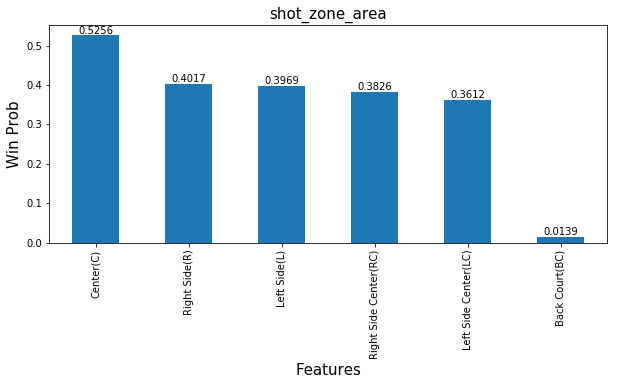

In [6]:
import operator
feature_name='shot_zone_area'
data = known_data
data[feature_name] = data[feature_name].astype('object')
data_features = data[feature_name];
data_features = pd.unique(data_features)
hit_rate = np.zeros((data_features.shape[0],1),dtype=np.float32)
hit_number = np.zeros((data_features.shape[0],1),dtype=np.float32)
i = 0
dic = {}
for t in data_features:
    sub_type = data.loc[data[feature_name] == t]
    nb_success_hit = sub_type.loc[sub_type['shot_made_flag'] == 1]
    nb_success_hit = nb_success_hit.shape[0]
    nb_fail_hit = sub_type.loc[sub_type['shot_made_flag'] == 0]
    nb_fail_hit = nb_fail_hit.shape[0]
    hit_number[i] = (nb_success_hit+nb_fail_hit)
    hit_rate[i] = nb_success_hit/(nb_success_hit+nb_fail_hit)
    # for the sorting to work    
    dic[t] = nb_success_hit/(nb_success_hit+nb_fail_hit)
    i += 1

# sort by dic key
sort_res = sorted(dic.items(), key=operator.itemgetter(1), reverse=True)

sort_f, sort_v = [], []
for f, v in sort_res:
    sort_f.append(f)
    sort_v.append(v)
    
freq_series = pd.Series.from_array(sort_v)
plt.figure(figsize=(10, 4))
ax = freq_series.plot(kind='bar')
ax.set_title(feature_name, fontsize=15)
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Win Prob', fontsize=15)
plt.xticks(rotation=90)
ax.set_xticklabels(sort_f)

rects = ax.patches

# Make some labels.
labels = ["{0:.4f}".format(i) for i in sort_v]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom')


# Data pre-processing and features selections

In [73]:
from sklearn import preprocessing

## Decide the data set
data = final_complete_data.copy()

## Features Transformation
#Time domain:
seconds = sort_and_partition(data, 'seconds_remaining', 20)

#Spatial domain:
distance = sort_and_partition(data, 'shot_distance', 10)

#Final Predictors
X = data[[u'loc_x',u'loc_y',
          u'shot_distance',
          u'season_accuracy',    
          #u'shot_distance_accuracy',
          u'last_5_sec_in_period',
          u'seconds_from_game_start',
          u'home_field',
          # uncommented 'game_date' for time series analysis
          u'game_date', 
         ]]
X = X.join(distance)
X = X.join(seconds)
categorial_variables = [
    'action_type', 'combined_shot_type', 'season', 
    'shot_zone_area', 'shot_zone_basic',             
    'opponent']
for cate in categorial_variables:
    dummies = pd.get_dummies(data[cate])
    dummies = dummies.add_prefix("{}_".format(cate))
    X = X.join(dummies)
X_test = X.head(5000)
X_train = X.tail(25697)

#Dependent
y = data[u'shot_made_flag']
y_test = y.head(5000)
y_train = y.tail(25697)

#Save Transformed Data
Known_Data_Transformed = pd.concat([X_train,y_train],axis=1)
Known_Data_Transformed = Known_Data_Transformed.reindex()
Unknown_Data_Transformed = pd.concat([X_test,y_test],axis=1)
Unknown_Data_Transformed = Unknown_Data_Transformed.reindex()
Final_Data_Transformed = Unknown_Data_Transformed.append(Known_Data_Transformed)
Final_Data_Transformed.to_csv('Final_Data_Transformed.csv')

#Dataframe to matrix
X_test = X_test.as_matrix()
X_train = X_train.as_matrix()
y_test = y_test.as_matrix()
y_train = y_train.as_matrix()

#Print Shapoe
print(X_train.shape)
print(X_test.shape)

(25697, 148)
(5000, 148)


# Logistic Regression

In [58]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)

LR = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, \
                        intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', \
                        max_iter=10000, multi_class='ovr', verbose=0, warm_start=False)
LR.fit(X_train,y_train)
y_predict_proba_LR = LR.predict_proba(X_test)

score_test = log_loss(y_test, y_predict_proba_LR[:,1])
y_predict_proba_LR_train = LR.predict_proba(X_train)
score_training= log_loss(y_train, y_predict_proba_LR_train[:,1])
accuracy = accuracy_score(y_test, LR.predict(X_test))
print('Accuracy: %f' %accuracy)
print('Log loss test: %f' %score_test)
print('Roc: %f' %roc_auc_score(y_test, y_predict_proba_LR[:,1]))

Accuracy: 0.680600
Log loss test: 0.609189
Roc: 0.696657


## Decision Tree

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

for mdepth in [4]:
    clf_gini = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = mdepth)
    clf_gini.fit(X_train, y_train)
    y_predict_proba_clf_gini = clf_gini.predict_proba(X_test)
    score = log_loss(y_test, y_predict_proba_clf_gini[:,1]) 
    print('Log loss Gini: %f' %score)
    print('Accuracy: %f' %accuracy_score(y_test, clf_gini.predict(X_test)))
    print('RoC score: %f' %roc_auc_score(y_test, y_predict_proba_clf_gini[:,1]))

    clf_entropy = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = mdepth)
    clf_entropy.fit(X_train, y_train)
    y_predict_proba_clf_entropy = clf_entropy.predict_proba(X_test)
    score = log_loss(y_test, y_predict_proba_clf_entropy[:,1]) 
    print('Log loss Entropy: %f' %score)
    print('Accuracy: %f' %accuracy_score(y_test, clf_entropy.predict(X_test)))
    print('RoC score: %f' %roc_auc_score(y_test, y_predict_proba_clf_entropy[:,1]))


Log loss Gini: 0.610539
Accuracy: 0.678400
RoC score: 0.695851
Log loss Entropy: 0.630356
Accuracy: 0.679800
RoC score: 0.691683


# Random Forest

In [60]:
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)

# RFC = RandomForestClassifier()
# parameters_RFC = {'n_estimators':[100],'criterion':['entropy'],'random_state':[42]}
# grid_search_RFC = GridSearchCV(RFC, parameters_RFC)                             
# grid_search_RFC.fit(X_train,y_train)
# best_n_estimators_RFC = grid_search_RFC.best_params_['n_estimators']
# best_criterion_RFC = grid_search_RFC.best_params_['criterion']

for n in [950]:
    RFC_Best = RandomForestClassifier(n_estimators=n, criterion='entropy',n_jobs=-1)
    RFC_Best.fit(X_train,y_train)
    y_predict_proba_RFC = RFC_Best.predict_proba(X_test)
    accuracy_score_RFC = accuracy_score(y_test, RFC_Best.predict(X_test))
    roc_auc_score_RFC = roc_auc_score(y_test, y_predict_proba_RFC[:,1])
    score = log_loss(y_test, y_predict_proba_RFC[:,1])
    print('nEstimator: %d' %n)
    print('Logloss: %f' %score)
    print('Accuracy: %f' %accuracy_score(y_test, RFC_Best.predict(X_test)))
    print('ROC: %f' %roc_auc_score_RFC)

nEstimator: 950
Logloss: 0.611655
Accuracy: 0.673600
ROC: 0.699309


# AdaBoost

In [61]:
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)

for n in [100]:
    for lr in [0.0035]:
        AdaBC_Best = AdaBoostClassifier(n_estimators=n, learning_rate=lr)
        AdaBC_Best.fit(X_train,y_train)
        y_predict_proba_AdaBC = AdaBC_Best.predict_proba(X_test)
        accuracy_score_AdaBC = accuracy_score(y_test, AdaBC_Best.predict(X_test))
        roc_auc_score_AdaBC = roc_auc_score(y_test, y_predict_proba_AdaBC[:,1])
        score = log_loss(y_test, y_predict_proba_AdaBC[:,1])
        print('nEstimator: %d' %n)
        print('learning_rate: %f' %lr)
        print('Logloss: %f' %score)
        print('Accuracy: %f' %accuracy_score(y_test, AdaBC_Best.predict(X_test)))
        print('ROC: %f' %roc_auc_score_AdaBC)

nEstimator: 100
learning_rate: 0.003500
Logloss: 0.642629
Accuracy: 0.658800
ROC: 0.649930


# GBDT

In [57]:
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)
from sklearn.metrics import make_scorer

for n in [950]:
    for mdepth in [7]:
        GBDT_Best = GradientBoostingClassifier(n_estimators=n, learning_rate=0.0038, max_depth = mdepth)
        GBDT_Best.fit(X_train,y_train)
        y_predict_proba_GBDT = GBDT_Best.predict_proba(X_test)
        accuracy_score_GBDT = accuracy_score(y_test, GBDT_Best.predict(X_test))
        roc_auc_score_GBDT = roc_auc_score(y_test, y_predict_proba_GBDT[:,1])
        score = log_loss(y_test, y_predict_proba_GBDT[:,1])

        print('Logloss: %f' %score)
        print('Accuracy: %f' %accuracy_score(y_test, GBDT_Best.predict(X_test)))
        print('ROC: %f' %roc_auc_score_GBDT)

Logloss: 0.602740
Accuracy: 0.680400
ROC: 0.710693


# XGBoost

In [36]:
from xgboost import XGBClassifier
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.model_selection import GridSearchCV

for n in [1050]:
    XGB_Best = XGBClassifier(n_estimators=n,\
                             learning_rate=0.0038,\
                             max_depth=10,\
                             min_child_weight = 3,\
                             max_delta_step = 1,\
                             colsample_bytree = 0.7,\
                             objective='binary:logistic',\
                             n_jobs=-1,\
                             silent = 1,\
                             eval_metric = 'logloss')
    XGB_Best.fit(X_train,y_train)
    y_predict_proba_XGB = XGB_Best.predict_proba(X_test)
    accuracy_score_XGB = accuracy_score(y_test, XGB_Best.predict(X_test))
    roc_auc_score_XGB = roc_auc_score(y_test, y_predict_proba_XGB[:,1])
    score = log_loss(y_test, y_predict_proba_XGB[:,1])
    print(n)
    print('Log loss: %f' %score)    
    print('Accuracy: %f' %accuracy_score_XGB)    
    print('ROC score: %f' %roc_auc_score_XGB)    


1050
Log loss: 0.599826
Accuracy: 0.682400
ROC score: 0.714536


# Neural Network

In [35]:
from sklearn.neural_network import MLPClassifier
#for n in range(20,200,50):
NN = MLPClassifier(solver='adam', activation='tanh', alpha=0.01, hidden_layer_sizes=(100,80,70,60,20,10))
NN.fit(X_train, y_train)                         
y_predict_proba_NN = NN.predict_proba(X_test)
accuracy_score_NN = accuracy_score(y_test, NN.predict(X_test))
roc_auc_score_NN = roc_auc_score(y_test, y_predict_proba_NN[:,1])
score = log_loss(y_test, y_predict_proba_NN[:,1])
y_predict_proba_NN_train = NN.predict_proba(X_train)
score_training= log_loss(y_train, y_predict_proba_NN_train[:,1])

print('Log loss: %f' %score)    
print('Accuracy: %f' %accuracy_score_NN)    
print('ROC score: %f' %roc_auc_score_NN)  



Log loss: 0.670576
Accuracy: 0.603600
ROC score: 0.592918


## ROC diagram

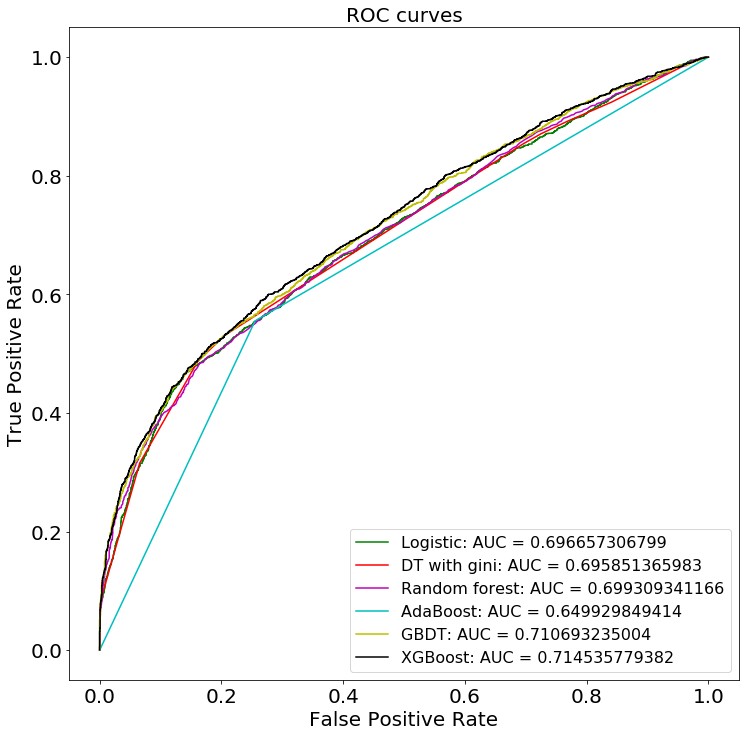

In [72]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib

# LR
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_predict_proba_LR[:,1])
AUC_LR = roc_auc_score(y_test, y_predict_proba_LR[:,1])

# DT with gini
fpr_gini, tpr_gini, thresholds_gini = roc_curve(y_test, y_predict_proba_clf_gini[:,1])
AUC_gini = roc_auc_score(y_test, y_predict_proba_clf_gini[:,1])

# # DT with entropy
# fpr_entropy, tpr_entropy, thresholds_entropy = roc_curve(y_test, y_predict_proba_clf_entropy[:,1])
# AUC_entropy = roc_auc_score(y_test, y_predict_proba_clf_entropy[:,1])

# Random Forest
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_predict_proba_RFC[:,1])
AUC_RF = roc_auc_score(y_test, y_predict_proba_RFC[:,1])

# AdaBoost
fpr_Ada, tpr_Ada, thresholds_Ada = roc_curve(y_test, y_predict_proba_AdaBC[:,1])
AUC_Ada = roc_auc_score(y_test, y_predict_proba_AdaBC[:,1])

# GBDT
fpr_GBDT, tpr_GBDT, thresholds_GBDT = roc_curve(y_test, y_predict_proba_GBDT[:,1])
AUC_GBDT = roc_auc_score(y_test, y_predict_proba_GBDT[:,1])

# XGBoost
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_predict_proba_XGB[:,1])
AUC_XGB = roc_auc_score(y_test, y_predict_proba_XGB[:,1])

# Neural Networs
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_predict_proba_NN[:,1])
AUC_NN = roc_auc_score(y_test, y_predict_proba_NN[:,1])

Fig = plt.figure(figsize=(12,12)) 
LR_plot, = plt.plot(fpr_LR, tpr_LR, 'g', label="Logistic: AUC = " + str(AUC_LR))
GINI_plot, = plt.plot(fpr_gini, tpr_gini, 'r', label="DT with gini: AUC = " + str(AUC_gini))
#ENTROPY_plot, = plt.plot(fpr_entropy, tpr_entropy, 'b', label="DT with entropy: AUC = " + str(AUC_entropy))
RF_plot, = plt.plot(fpr_RF, tpr_RF, 'm', label="Random forest: AUC = " + str(AUC_RF))
Ada_plot, = plt.plot(fpr_Ada, tpr_Ada, 'c', label="AdaBoost: AUC = " + str(AUC_Ada))
GBDT_plot, = plt.plot(fpr_GBDT, tpr_GBDT, 'y', label="GBDT: AUC = " + str(AUC_GBDT))
XGB_plot, = plt.plot(fpr_XGB, tpr_XGB, 'k', label="XGBoost: AUC = " + str(AUC_XGB))
#XGB_plot, = plt.plot(fpr_NN, tpr_NN, 'r', label="Neural Network: AUC = " + str(AUC_NN))
matplotlib.rcParams.update({'font.size': 20})
plt.legend(handles=[LR_plot, GINI_plot, RF_plot, Ada_plot, GBDT_plot, XGB_plot])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC curves', fontsize=20)
plt.legend(fontsize = 16, loc = 0)
plt.show()
Fig.savefig('RoC.eps', format='eps',dpi=1200)

## Time Series Test with LR

In [75]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from xgboost import XGBClassifier
import xgboost as xgb

predic_prob = np.zeros((5000,1),dtype=float)
predic = np.zeros((5000,1),dtype=float)

i=0
start = 0
for raw_date in pd.unique(Unknown_Data_Transformed['game_date']):
    Sub_Known_Data_Transformed = Known_Data_Transformed[Known_Data_Transformed.apply(lambda x: x['game_date'] <= raw_date, axis=1)]
    #Sub_Known_Data_Transformed = Known_Data_Transformed
    Sub_Known_Data_Transformed = Sub_Known_Data_Transformed.drop(['game_date'], axis=1)
    number_allowable_data = Sub_Known_Data_Transformed.shape[0]
    
    #Dataframe to matrix training
    X_sub_training = Sub_Known_Data_Transformed.drop(['shot_made_flag'], axis=1)
    X_sub_training = X_sub_training.as_matrix()
    y_sub_train = Sub_Known_Data_Transformed['shot_made_flag']
    y_sub_train = y_sub_train.as_matrix()
      
    #Training Model
#     XGB_Best = XGBClassifier(n_estimators=1050,\
#                              learning_rate=0.0038,\
#                              max_depth=10,\
#                              min_child_weight = 3,\
#                              max_delta_step = 1,\
#                              colsample_bytree = 0.7,\
#                              objective='binary:logistic',\
#                              n_jobs=-1,\
#                              silent = 1,\
#                              eval_metric = 'logloss')
#     XGB_Best.fit(X_sub_training,y_sub_train) 

    LR = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, \
                        intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', \
                        max_iter=10000, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
    LR.fit(X_sub_training,y_sub_train)
    
    XGB_Best = LR
    
    #Prediction Process
    to_predict = Unknown_Data_Transformed[Unknown_Data_Transformed.apply(lambda x: x['game_date'] == raw_date, axis=1)]
    #to_predict = Unknown_Data_Transformed
    to_predict = to_predict.drop(['shot_made_flag','game_date'], axis=1)
    to_predict = to_predict.as_matrix()
    y_predict_proba_XGB = XGB_Best.predict_proba(to_predict)
    number_predict = y_predict_proba_XGB.shape[0]
    y_predict_proba = y_predict_proba_XGB[:,1]
    y_predict_proba = y_predict_proba.reshape(-1,1)
    predic_prob[start:start+number_predict] = y_predict_proba
    y_predict = XGB_Best.predict(to_predict)
    y_predict = y_predict.reshape(-1,1)
    predic[start:start+number_predict] = y_predict
    
    #Prediction for next date
    start = start+number_predict
    if start >= 5000:
        break
y_test = Unknown_Data_Transformed['shot_made_flag']
y_test = y_test.as_matrix()
y_test_sub = y_test[0:start]
accuracy = accuracy_score(y_test_sub, predic[0:start])
score_test = log_loss(y_test_sub, predic_prob[0:start])
print('accuracy %f' %accuracy)
print('log loss %f' %score_test)

accuracy 0.675600
log loss 0.628203


## Time Series Test with XGBoost

In [126]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from xgboost import XGBClassifier
import xgboost as xgb

predic_prob = np.zeros((5000,1),dtype=float)
predic = np.zeros((5000,1),dtype=float)

i=0
start = 0
for raw_date in pd.unique(Unknown_Data_Transformed['game_date']):
    Sub_Known_Data_Transformed = Known_Data_Transformed[Known_Data_Transformed.apply(lambda x: x['game_date'] <= raw_date, axis=1)]
    #Sub_Known_Data_Transformed = Known_Data_Transformed
    Sub_Known_Data_Transformed = Sub_Known_Data_Transformed.drop(['game_date'], axis=1)
    number_allowable_data = Sub_Known_Data_Transformed.shape[0]
    
    #Dataframe to matrix training
    X_sub_training = Sub_Known_Data_Transformed.drop(['shot_made_flag'], axis=1)
    X_sub_training = X_sub_training.as_matrix()
    y_sub_train = Sub_Known_Data_Transformed['shot_made_flag']
    y_sub_train = y_sub_train.as_matrix()
      
    #Training Model
    XGB_Best = XGBClassifier(n_estimators=1050,\
                             learning_rate=0.0038,\
                             max_depth=10,\
                             min_child_weight = 3,\
                             max_delta_step = 1,\
                             colsample_bytree = 0.7,\
                             objective='binary:logistic',\
                             n_jobs=-1,\
                             silent = 1,\
                             eval_metric = 'logloss')
    XGB_Best.fit(X_sub_training,y_sub_train) 

#     LR = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, \
#                         intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', \
#                         max_iter=10000, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
#     LR.fit(X_sub_training,y_sub_train)
    
#     XGB_Best = LR
    
    #Prediction Process
    to_predict = Unknown_Data_Transformed[Unknown_Data_Transformed.apply(lambda x: x['game_date'] == raw_date, axis=1)]
    #to_predict = Unknown_Data_Transformed
    to_predict = to_predict.drop(['shot_made_flag','game_date'], axis=1)
    to_predict = to_predict.as_matrix()
    y_predict_proba_XGB = XGB_Best.predict_proba(to_predict)
    number_predict = y_predict_proba_XGB.shape[0]
    y_predict_proba = y_predict_proba_XGB[:,1]
    y_predict_proba = y_predict_proba.reshape(-1,1)
    predic_prob[start:start+number_predict] = y_predict_proba
    y_predict = XGB_Best.predict(to_predict)
    y_predict = y_predict.reshape(-1,1)
    predic[start:start+number_predict] = y_predict
    
    #Prediction for next date
    start = start+number_predict
    print(start)
    if start >= 5000:
        break
y_test = Unknown_Data_Transformed['shot_made_flag']
y_test = y_test.as_matrix()
y_test_sub = y_test[0:start]
accuracy = accuracy_score(y_test_sub, predic[0:start])
score_test = log_loss(y_test_sub, predic_prob[0:start])
print('accuracy %f' %accuracy)
print('log loss %f' %score_test)

2
4
12
15
18
23
27
34
36
42
43
47
50
54
56
59
63
65
69
73
75
78
82
85
89
92
97
101
103
105
109
114
119
124
131
132
136
142
147
152
158
164
167
175
178
180
184
185
191
198
199
201
204
206
207
210
215
216
219
221
223
225
227
229
233
236
240
244
247
249
251
253
259
263
266
267
268
270
275
280
281
285
286
291
295
297
301
303
307
308
313
315
317
322
325
327
330
333
339
344
351
357
361
363
366
367
370
372
373
374
377
381
382
384
385
392
394
397
399
403
406
409
413
416
419
420
427
428
431
434
438
440
442
445
449
452
454
462
465
469
471
474
479
482
486
488
494
497
498
506
508
513
519
525
529
535
537
541
542
545
547
550
551
553
554
557
561
564
571
579
582
585
594
598
600
609
615
617
621
624
627
629
632
633
640
644
646
655
661
662
668
677
681
695
700
707
712
714
717
719
724
730
734
736
741
745
747
755
757
761
770
772
774
778
780
783
786
787
790
793
798
799
802
808
810
815
821
824
825
828
830
831
834
835
839
844
847
852
855
858
864
866
870
874
877
881
883
887
888
890
893
897
899
901
905
907
908
9

KeyboardInterrupt: 

In [127]:
y_test = Unknown_Data_Transformed[[u'shot_made_flag',u'game_date']]
y_test['prob'] = predic_prob
y_test['predic'] = predic
y_test = y_test.sort_values('game_date')
unknown_date = pd.unique(Unknown_Data_Transformed['game_date'])
N_unknown_date = unknown_date.shape[0]
accuracy_arr = np.zeros((N_unknown_date,1),dtype=float)
logloss_arr = np.zeros((N_unknown_date,1),dtype=float)
i=0
for raw_date in pd.unique(y_test['game_date']):
    Sub_y_test = y_test[y_test.apply(lambda x: x['game_date'] <= raw_date, axis=1)]
    y_test_predic = Sub_y_test['predic']
    y_test_predic = y_test_predic.as_matrix()
    y_test_true = Sub_y_test['shot_made_flag']
    y_test_true = y_test_true.as_matrix()
    y_test_prob = Sub_y_test['prob']
    y_test_prob = y_test_prob.as_matrix()
    accuracy_arr[i] = accuracy_score(y_test_true, y_test_predic)
    logloss_arr[i]= log_loss(y_test_true, y_test_prob)
    i= i + 1

In [ ]:
Fig2 = plt.figure(figsize=(10,10)) 
plt.plot(range(0,N_unknown_date,1),accuracy_arr,linewidth=8)
matplotlib.rcParams.update({'font.size': 20})
plt.xlabel('Index of shot to be predicted with their dates in ascending order', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Time Series Analysis', fontsize=20)
plt.show()
Fig2.savefig('Accuracy.eps', format='eps', dpi=1000)

Fig3, ax = plt.subplots(figsize=(10, 10)) # create a new figure with a default 111 subplot
ax.plot(range(0,N_unknown_date,1),logloss_arr,linewidth=8)
matplotlib.rcParams.update({'font.size': 20})
ax.set_xlabel('Index of shot to be predicted with their dates in ascending order', fontsize=20)
ax.set_ylabel('Log Loss', fontsize=20)
ax.set_title('Time Series Analysis', fontsize=20)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins = zoomed_inset_axes(ax, 2, loc=1)
axins.plot(range(0,N_unknown_date,1),logloss_arr,linewidth=4)
x1, x2, y1, y2 = 10, 300, 0.62, 4 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.autoscale
plt.yticks(visible=True)
plt.xticks(visible=True)
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
Fig3.savefig('Logloss.eps', format='eps', dpi=1000)

In [ ]:
y_test = Unknown_Data_Transformed[[u'shot_made_flag',u'game_date']]
y_test['prob'] = predic_prob
y_test['predic'] = predic
y_test = y_test.sort_values('game_date')
y_test_predic = y_test['predic']
y_test_predic = y_test_predic.as_matrix()
y_test_true = y_test['shot_made_flag']
y_test_true = y_test_true.as_matrix()
y_test_prob = y_test['prob']
y_test_prob = y_test_prob.as_matrix()
accuracy_arr = np.zeros((5000,1),dtype=float)
logloss_arr = np.zeros((5000,1),dtype=float)

for n in range(1,5001,1):
    accuracy_arr[n-1] = accuracy_score(y_test_true[0:n], y_test_predic[0:n])
    if n > 3:
        logloss_arr[n-1] = log_loss(y_test_true[0:n], y_test_prob[0:n])
plt.figure(figsize=(8,6)) 
a_range = range(0,5000,1)
plt.plot(a_range,accuracy_arr)

plt.figure(figsize=(8,6)) 
a_range = range(500,5000,1)
plt.plot(a_range,logloss_arr[500:5000])